In [21]:
import pandas as pd
import numpy as np

#Pyrepseq imports
import pyrepseq as prs
from pyrepseq import pc

#Plotting imports
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.style 
import matplotlib as mpl 
import seaborn as sns

In [22]:
#Set default plotting parameters
mpl.rcParams['figure.figsize'] = [4.0, 4.0] 
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=500 

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Data imports

### Specific sequences - VDJdb

In [23]:
vdjdb = pd.read_csv('../../data/vdjdb/vdjdb_paired_human_preprocessed.csv',sep=',')

vdjdb = vdjdb.dropna(axis=0, subset = ["CDR3B", "TRBV", "TRBJ", "CDR3A", "TRAV", "TRAJ"] ).reset_index().drop("index", axis=1)

### Background sequences - tanno

In [24]:
tanno = pd.read_csv('../../data/tanno/preprocessed/combined.csv',sep=',')
tanno = tanno.dropna(axis=0, subset = ["CDR3B", "TRBV", "TRBJ", "CDR3A", "TRAV", "TRAJ"] ).reset_index().drop("index", axis=1)


## Testing TCR info functions

### pc joint and pc conditional

In [25]:
import warnings

In [26]:
def pc_joint(df, on):
    "Joint coincidence probability estimator"

    return pc(df[on].sum(1))

def pc_conditional(df, by, on, weight=True, suppress_warnings=True):
    "Conditional coincidence probability estimator"
    
    #Disable warnings
    if suppress_warnings:
        warnings.filterwarnings('ignore')
        
    #Check if a joint or lone probability is required
    if type(on) == str or type(on) == np.str_:
        p = df.groupby(by).apply(lambda x: pc(x[on]))

    else:
        p = df.groupby(by).apply(lambda x: pc_joint(x,on))
    
    #Mask p values for which there was insufficient data to compute pc
    mask = ~np.isnan(p)
    counts =  df.groupby(by).size()[mask]
    weights = np.ones(len(counts))/len(counts)
    if weight:
        
        #Calculate probability of each grouping
        weights = counts/counts.sum()
    
    mean_pc = np.sum(weights*p[mask]**0.5)**2
    
    if suppress_warnings:
        warnings.filterwarnings('default')

    return mean_pc

### Renyi entropy 

In [27]:
def renyi2_entropy(df, features, by=None, base=2.0):
    """Compute Renyi-Simpson entropies.
    """

    if base is not None and base <= 0:
        raise ValueError("`base` must be a positive number or `None`.")

    # Check if multiple features are given or a single feature
    if type(features) == str or type(features) == np.str_:
        features = [features]
    
    # Check for single term groupby
    if by is not None and len(by) == 1:
        by = by[0]
    
    if not by:
        entropy = -np.log(pc_joint(df, features))
    else:
        entropy = -np.log(pc_conditional(df, by, features))

    if base is not None:
        entropy /= np.log(base) 
    return entropy

### Relevance

In [28]:
def relevance(df_spc, df_back, features, by=[], spc_group_column=None):
    """ Calculate relevance score/joint relevance score of provided features
    """
    
    if spc_group_column is None:
        by_spc = by

    else:
        by_spc = by + [spc_group_column]
    
    return (renyi2_entropy(df_back, features, by) - renyi2_entropy(df_spc, features, by_spc))

### Relevance dict

In [29]:
def feature_relevance_dict(df_spc, df_back, features, by=[], spc_group_column=None):
    """ Calculate a dictionary of feature relevance scores.
    """
        
    relevance_dict = {"features":features}
    for i, feature in enumerate(features):
        # Compute relevance
        relevance_dict[feature] = relevance(df_spc, df_back, feature, by, spc_group_column)
        
        for feature_2 in np.delete(features,i):
            # Compute joint relevance
            relevance_dict[feature+"+"+feature_2] =  relevance(df_spc, df_back, [feature, feature_2], by, spc_group_column)
            
    return relevance_dict

In [30]:
rel_dict = feature_relevance_dict(vdjdb, tanno, ["CDR3B", "TRBV"], spc_group_column="Epitope")

In [31]:
rel_dict

{'features': ['CDR3B', 'TRBV'],
 'CDR3B': 11.632405306040596,
 'CDR3B+TRBV': 14.016909520997206,
 'TRBV': 0.49367800975166753,
 'TRBV+CDR3B': 14.016909520997206}

In [54]:
def plot_relevance_grid(rel_dict, figsize = (3,3), dpi=500, vmin=0, vmax=25):
    
    grid = np.zeros((len(rel_dict["features"]),len(rel_dict["features"])))
    for i, feature_1 in enumerate(rel_dict["features"]):
        for j, feature_2 in enumerate(rel_dict["features"]):
            if i==j:
                grid[i,j] = rel_dict[feature_1]
                
            else:
                grid[i,j] = rel_dict[feature_1+"+"+feature_2]
                
                
    df = pd.DataFrame(grid, index=rel_dict["features"], columns=rel_dict["features"])
    
    fig, ax = plt.subplots(figsize = figsize, dpi = dpi)
    sns.heatmap(df, square='true', cmap='Blues', ax=ax, cbar_kws={'label': r'$I_2(x+y, \pi)$ bits'}
                ,vmin=vmin,vmax=vmax,annot=True)
    
    ax.set_facecolor('xkcd:black')
    ax.set_xlabel("x")
    ax.set_ylabel("y")

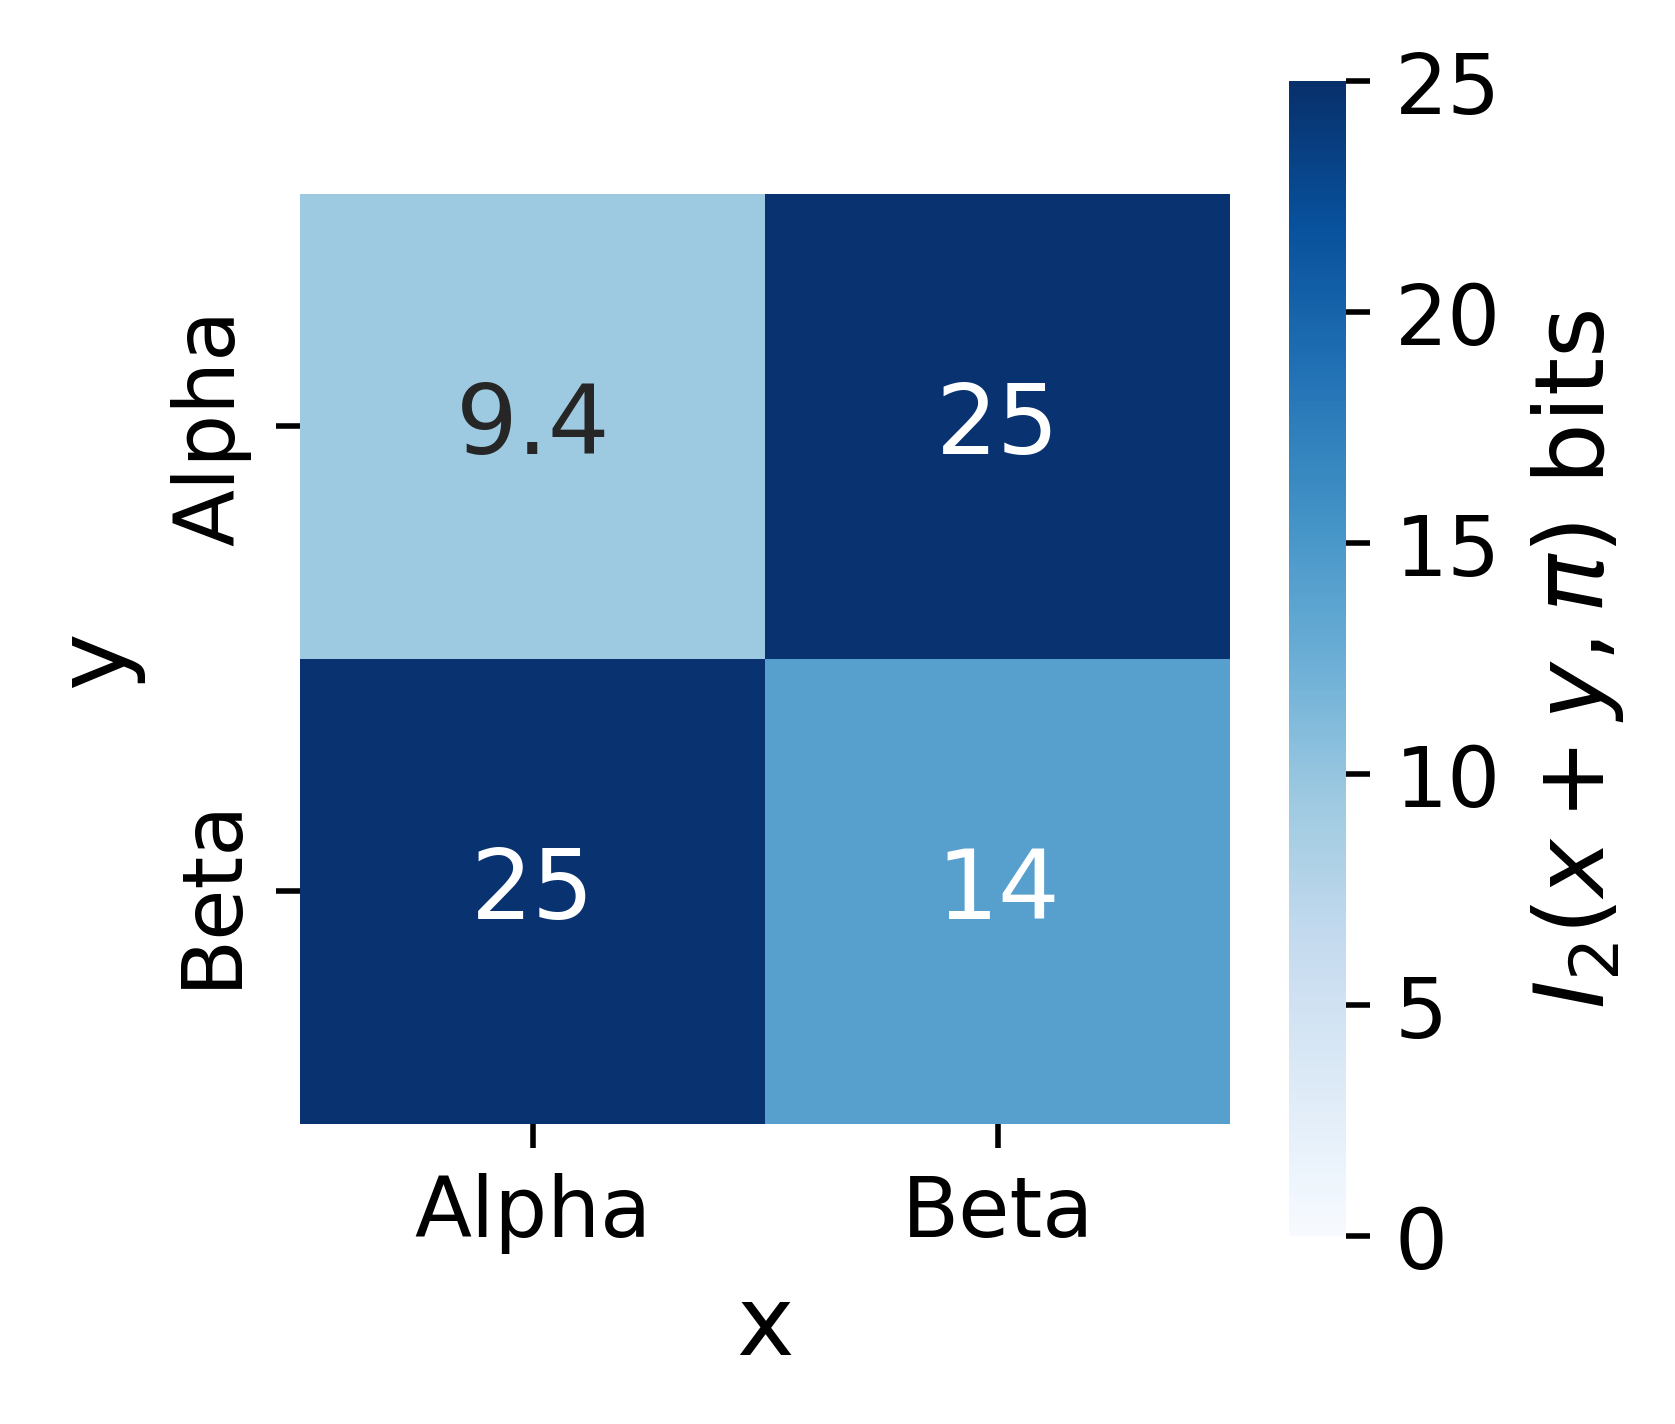

In [55]:
plot_relevance_grid(rel_dict)